<a href="https://colab.research.google.com/github/rahuldave/LearningJax/blob/main/Jax_GD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# solving y=mx+b on a TPU

_part of the [solving y=mx+b... with jax on a tpu pod slice](http://matpalm.com/blog/ymxb_pod_slice/) blog series_

in the last colab we introduced some key jax transforms. 

in this colab we'll use them to fit a simple `y=mx+b` model using squared loss; both on a single device as well as across 8 devices in a data parallelism approach.

while the approach described here is clearly overkill for such a trivial model it's good to work through something simple to focus on the tooling

In [6]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

setup stuff for runtime TPU or CPU

In [7]:
USE_TPU = False

if USE_TPU:
  import jax
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
else:
  # x8 cpu devices  
  import os
  os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=2'

In [8]:
import jax
jax.devices()
num_replicas = len(jax.devices())

In [9]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import make_jaxpr

we start by generating training data for a simple line with a bit of noise

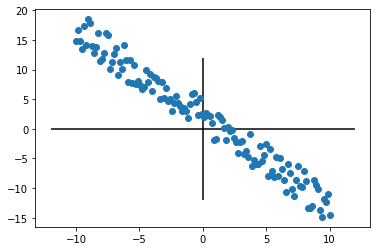

In [10]:
def y(x, m, b):
  return m * x + b

datasize = 128
x = np.linspace(-10, 10, num=datasize)
np.random.shuffle(x)

m_true = -1.5
b_true = 2.0

y_true = y(x, m_true, b_true)

noise = ((np.random.rand(*y_true.shape) * 2) - 1) * 3
y_true += noise

plt.plot(x, y_true, 'o')
plt.vlines(0, -12, 12)
plt.hlines(0, -12, 12)
plt.show()

we will be trying to solve for `(m, b)` and can start with some arbitrary values, which are clearly wrong

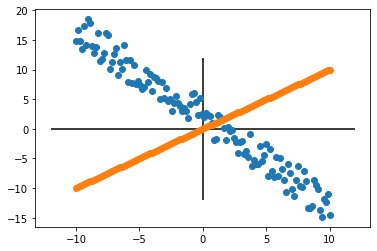

In [11]:
m_model = 1.0
b_model = 0.0

y_pred = y(x, m_model, b_model)
plt.plot(x, y_true, 'o')
plt.plot(x, y_pred, 'o')
plt.vlines(0, -12, 12)
plt.hlines(0, -12, 12)
plt.show()

we'll start by using `grad` for calculating an update to our model params `(m, b)` with respect to a loss function

In [12]:
from jax import grad, jit

def sqr_loss(y_true, y_pred):
  return jnp.mean((y_true-y_pred)**2)

def loss_wrt_params(x, m, b, y_true):
  y_pred = y(x, m, b)
  return sqr_loss(y_true, y_pred)

# note: by dft grad calculates gradients w.r.t the first arg
#  but in this case we want it w.r.t. m & b, i.e. args 1 & 2
gradient_wrt_loss = jit(grad(loss_wrt_params, argnums=(1, 2)))

m_grad, b_grad = gradient_wrt_loss(x, m_true, b_true, y_true)
print("for true: m_grad", m_grad , "b_grad", b_grad)

m_grad, b_grad = gradient_wrt_loss(x, m_model, b_model, y_true)
print("for model params: m_grad", m_grad , "b_grad", b_grad)

for true: m_grad -2.203858 b_grad 0.38934892
for model params: m_grad 167.08748 b_grad -3.610651


we can use this gradient to run a trivial learning loop

In [13]:
m, b = 1.0, 0.0
learning_rate = 0.01

print("true", m_true, b_true)
for _ in range(30):
  m_grad, b_grad = gradient_wrt_loss(x, m_model, b_model, y_true)
  m_model -= learning_rate * m_grad 
  b_model -= learning_rate * b_grad 
  print("grads", m_grad, b_grad , "=> model", m_model, b_model)

true -1.5 2.0
grads 167.08748 -3.610651 => model -0.6708747 0.03610651
grads 53.941635 -3.5384378 => model -1.210291 0.071490884
grads 17.41423 -3.4676695 => model -1.3844333 0.10616758
grads 5.6219215 -3.398316 => model -1.4406525 0.14015074
grads 1.8149496 -3.3303494 => model -1.458802 0.17345424
grads 0.58592945 -3.2637424 => model -1.4646612 0.20609167
grads 0.18916094 -3.1984677 => model -1.4665529 0.23807634
grads 0.061067313 -3.1344984 => model -1.4671636 0.26942134
grads 0.01971218 -3.0718083 => model -1.4673607 0.30013943
grads 0.0063598454 -3.0103722 => model -1.4674244 0.33024314
grads 0.002050072 -2.9501648 => model -1.4674449 0.3597448
grads 0.0006609708 -2.8911614 => model -1.4674515 0.3886564
grads 0.00021739304 -2.8333385 => model -1.4674536 0.4169898
grads 7.161498e-05 -2.7766714 => model -1.4674543 0.4447565
grads 2.3335218e-05 -2.721138 => model -1.4674546 0.47196788
grads 7.1674585e-06 -2.6667156 => model -1.4674547 0.49863502
grads -5.066395e-07 -2.613381 => model 

## pytrees

before we start though we should know that most models have more than 2 params. another thing we can do then is make use of the fact that the fundamental jax operators can work with dictionaries of params, called [pytrees](https://jax.readthedocs.io/en/latest/pytrees.html). this allows us to work with a single `params` object rather than clumsily having to manage single parameters

In [14]:
def y(params, x):
  return params['m'] * x + params['b']

def mean_sqrd_loss(params, x, y_true):
  y_pred = y(params, x)
  loss = (y_pred - y_true) ** 2
  return jnp.mean(loss)

note how transforms like `grad` are pytree aware and it return gradients in the same structure as the params

In [15]:
true_params = {'m': m_true, 'b': b_true}
model_params = {'m': 1.0, 'b': 0.0}

# recall signature: mean_sqrd_loss(params, x, y_true)
# note: grad takes gradients with respect to first arg
grads = jit(grad(mean_sqrd_loss))

print("grads w.r.t true_params", grads(true_params, x, y_true))
print("grads w.r.t model_params", grads(model_params, x, y_true))

grads w.r.t true_params {'b': DeviceArray(0.38934892, dtype=float32, weak_type=True), 'm': DeviceArray(-2.203858, dtype=float32, weak_type=True)}
grads w.r.t model_params {'b': DeviceArray(-3.610651, dtype=float32, weak_type=True), 'm': DeviceArray(167.08748, dtype=float32, weak_type=True)}


##pmap

let's run `pmap` to calc gradients in parallel. we'll reshape the input `(x, y)` data so we can `pmap` it across the 8 devices. we won't `pmap` across the model params `m` or `b`. this is effectively running a data parallel approach where each device runs the same model, but on 1/8th of the data. 

In [16]:
# reshape x and y_true to 8 sets of 16 examples
shardsize = datasize//num_replicas
x = x.reshape((num_replicas, shardsize))
y_true = y_true.reshape((num_replicas, shardsize))

if we pmap over the gradient calc directly what we end up getting is the 8 sets of gradients, each of which corresponds to the 16 examples that were provided. note how this represents the fundamental data parallelism approach.

In [17]:
from jax import pmap

# recall signature: mean_sqrd_loss(params, x, y_true)
p_grads = pmap(grad(mean_sqrd_loss), in_axes=(None, 0, 0))
p_grads(model_params, x, y_true)

{'b': ShardedDeviceArray([-4.935777, -2.285525], dtype=float32, weak_type=True),
 'm': ShardedDeviceArray([163.16254, 171.01242], dtype=float32, weak_type=True)}

at this point we have the gradients for each of the 8 batches of 16. we can sum these gradients and use them for an update.

In [18]:
g = p_grads(model_params, x, y_true)
g = {k: jnp.sum(v) for k, v in g.items()}
g

{'b': DeviceArray(-7.221302, dtype=float32),
 'm': DeviceArray(334.17496, dtype=float32)}

this kind of application of a function (like sum) to elements of a dictionary is pretty common when you represent params in dictionaries. to support operations on these jax provides a selection of `tree_utils` including `tree_map`. tree_map (and friends) can handle all kinds of potentially nested structures and run their operation on the leafs of the dict structure.

In [19]:
from jax.tree_util import tree_map 

g = p_grads(model_params, x, y_true)
g = tree_map(jnp.sum, g)
g

{'b': DeviceArray(-7.221302, dtype=float32),
 'm': DeviceArray(334.17496, dtype=float32)}

turns out this sum across all the 8 devices is something we can also do _inside_ the `pmap` call, not just after it. so far we've only used pmap to do independent calculations but there are a number of parallel ops we can call that operate _across_ the devices. in this case we can use `psum`. 

note how since `pmap` always returns a sharded value based on the #devices it broadcasts the gradients out to a replicated (8, 1) array. 

In [20]:
from jax.lax import psum

def p_grads(params, x, y_true):
  grads = jit(grad(mean_sqrd_loss))(params, x, y_true)
  grads = tree_map(lambda v: psum(v, 'device'), grads)
  return grads

p_grads = pmap(p_grads, in_axes=(None, 0, 0), axis_name='device')

model_params = {'m': 1.0, 'b': 0.0}
p_grads(model_params, x, y_true)

{'b': ShardedDeviceArray([-7.221302, -7.221302], dtype=float32),
 'm': ShardedDeviceArray([334.17496, 334.17496], dtype=float32)}

we've done the forward pass, the loss calc and now gradients all in parallel. what about the actual model update? we can do that in the `pmap` call too! we use the `tree_multimap` helper to update the params (a pytree) from the gradients (another pytree)

In [21]:
from jax.tree_util import tree_multimap

def p_update(params, x, y_true):
  # calculate gradients summing across all devices
  grads = jit(grad(mean_sqrd_loss))(params, x, y_true)
  grads = tree_map(lambda v: psum(v, 'device'), grads)  
  # apply update
  def update(p, g):  
    learning_rate = 0.001
    return p - learning_rate * g
  new_params = tree_multimap(update, params, grads)
  # return new params
  return new_params

p_update = pmap(p_update, in_axes=(None, 0, 0), axis_name='device')

model_params = {'m': 1.0, 'b': 0.0}
p_update(model_params, x, y_true)

/usr/local/lib/python3.7/dist-packages/jax/_src/tree_util.py:189: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  'instead as a drop-in replacement.', FutureWarning)


{'b': ShardedDeviceArray([0.0072213, 0.0072213], dtype=float32),
 'm': ShardedDeviceArray([0.665825, 0.665825], dtype=float32)}

again notice how in the return values the params are being promoted from scalars to sharded arrays . if we want to include this in some kind of `params = update(params)` kind of loop we need to also _start_ with a sharded set. we can do this by replicating the single model params across all the devices.

In [22]:
def shard(x):
  return pmap(lambda v: v)(x)

def replicate(x, replicas=num_replicas):  
  replicated = jnp.stack([x] * replicas)
  return shard(replicated)

model_params = {'m': 1.0, 'b': 0.0}
model_params = tree_map(replicate, model_params)
model_params

{'b': ShardedDeviceArray([0., 0.], dtype=float32, weak_type=True),
 'm': ShardedDeviceArray([1., 1.], dtype=float32, weak_type=True)}

and, while we're sharding, we might as well explicitly shard x and y too which has the nice side effect of replicating across the devices

In [23]:
x = shard(x)
y_true = shard(y_true)
  
x.shape, type(x)

((2, 64), jaxlib.xla_extension.pmap_lib.ShardedDeviceArray)

we now have everything we need to run this in across the eight devices in an as parallel way as possible

* the model params, x and y, are replicated across all 8 devices. i.e. all 8 devices have a copy of the same params.
* the data is also sharded aross the 8 devices. i.e. each device has 1/8th of the original data
* the forward pass, loss, gradient calc & param update is done in parallel with a minimal combine step for gradients.


In [24]:
from jax import value_and_grad

def p_update(params, x, y_true):
  # calculate gradients
  loss, grads = jit(value_and_grad(mean_sqrd_loss))(params, x, y_true)
  # do all reduce sum across all replicas
  grads = tree_map(lambda v: psum(v, 'device'), grads)  
  # apply update
  def update(p, g):  
    learning_rate = 0.001
    return p - learning_rate * g
  new_params = tree_multimap(update, params, grads)
  return new_params, loss

# note: we pmap across _all_ args now; model_params, x and y
p_update = pmap(p_update, in_axes=(0, 0, 0), axis_name='device')

for i in range(20):
  model_params, loss = p_update(model_params, x, y_true)  
  print("step", i , "loss", jnp.mean(loss), 
        "m", model_params['m'][0] , "b", model_params['b'][0])

/usr/local/lib/python3.7/dist-packages/jax/_src/tree_util.py:189: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  'instead as a drop-in replacement.', FutureWarning)


step 0 loss 212.40942 m 0.665825 b 0.0072213025
step 1 loss 160.328 m 0.37690836 b 0.014413719
step 2 loss 121.39202 m 0.1271206 b 0.021577366
step 3 loss 92.282 m -0.08883763 b 0.028712358
step 4 loss 70.5167 m -0.27554798 b 0.03581881
step 5 loss 54.241447 m -0.43697158 b 0.042896837
step 6 loss 42.069927 m -0.5765331 b 0.049946554
step 7 loss 32.965893 m -0.6971933 b 0.05696807
step 8 loss 26.154783 m -0.8015122 b 0.0639615
step 9 loss 21.057625 m -0.89170283 b 0.07092696
step 10 loss 17.241653 m -0.9696787 b 0.07786455
step 11 loss 14.383387 m -1.037094 b 0.0847744
step 12 loss 12.241029 m -1.0953791 b 0.0916566
step 13 loss 10.63384 m -1.1457704 b 0.09851128
step 14 loss 9.426725 m -1.1893371 b 0.105338536
step 15 loss 8.518703 m -1.2270035 b 0.11213849
step 16 loss 7.8342905 m -1.2595685 b 0.11891124
step 17 loss 7.317067 m -1.2877232 b 0.12565689
step 18 loss 6.9248567 m -1.3120648 b 0.13237557
step 19 loss 6.626137 m -1.3331097 b 0.13906737


what a way to solve `y=mx+b` !!